In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

features_df.csv  nslt_1000.json  nslt_300.json  videos/
missing.txt      nslt_100.json   sample.mp4     WLASL_v0.3.json
models/          nslt_2000.json  tmp/


In [ ]:
cd /content/drive/MyDrive/PFA/shared/PFA/wlasl-processed

/content/drive/.shortcut-targets-by-id/16gMgbmqNvGL7_NDEhCQmSV5JdsLllzfh/PFA/wlasl-processed


In [ ]:
ls

features_df.csv  nslt_1000.json  nslt_300.json  videos/
missing.txt      nslt_100.json   sample.mp4     WLASL_v0.3.json
models/          nslt_2000.json  tmp/


### **<font style="color:#112B3C"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [1]:
!pip install ez_setup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ez-setup: filename=ez_setup-0.9-py3-none-any.whl size=11015 sha256=d25f7cf79e4e4e7623422dac978cb54e8874199c0f7f234f31b51c2101452715
  Stored in directory: /root/.cache/pip/wheels/f4/78/bd/f88c8eddfd5a8bf2a029e5cd8bc7a9914597002b081a000ffe
Successfully built ez-setup


In [2]:
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install youtube-dl==2020.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.6 MB/s 


In [5]:
# import required libraries
import json
import os
import cv2
import pandas as pd
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [6]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

 ### **<font style="color:#112B3C">Load WLAS Dataset</font>**

In [ ]:
cd /content/drive/MyDrive/PFA/shared/PFA/wlasl-processed

/content/drive/.shortcut-targets-by-id/16gMgbmqNvGL7_NDEhCQmSV5JdsLllzfh/PFA/wlasl-processed


In [ ]:
main_path = ''
wlas_df = pd.read_json(main_path + 'WLASL_v0.3.json')

In [ ]:
wlas_df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [ ]:
ls

features_df.csv  nslt_1000.json  nslt_300.json  videos/
missing.txt      nslt_100.json   sample.mp4     WLASL_v0.3.json
models/          nslt_2000.json  tmp/


In [ ]:
wlas_df.iloc[1]["instances"][0]["video_id"], wlas_df.iloc[1]["instances"][0]["bbox"]

('69302', [551, 68, 1350, 1080])

In [ ]:
wlas_df.shape

(2000, 2)

### **<font style="color:#112B3C">Extract the available videos list from the dataset</font>**

In [ ]:
cd /content/drive/MyDrive/PFA/shared/PFA/wlasl-processed

/content/drive/.shortcut-targets-by-id/16gMgbmqNvGL7_NDEhCQmSV5JdsLllzfh/PFA/wlasl-processed


In [ ]:
ls

features_df.csv  nslt_1000.json  nslt_300.json  videos/
missing.txt      nslt_100.json   sample.mp4     WLASL_v0.3.json
models/          nslt_2000.json  tmp/


### **<font style="color:#112B3C">Extract the available videos list from the dataset</font>**

In [ ]:
def get_videos_ids(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids of the current instance
    
    input: instance json list
    output: list of videos_ids
    
    """
    videos_list = []    
    for ins in json_list:
        video_id = ins['video_id']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_list.append(video_id)
    return videos_list

In [ ]:
def get_json_features(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids and url or any other featrue of the current instance
    
    input: instance json list
    output: list of videos_ids
    
    """
    videos_ids = []
    videos_urls = []
    split_urls = []
    bboxs = []
    for ins in json_list:
        video_id = ins['video_id']
        video_url = ins['url']
        split = ins['split']
        bbox = ins['bbox']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_ids.append(video_id)
            videos_urls.append(video_url)
            split_urls.append(split)
            bboxs.append(bbox)
    return videos_ids, videos_urls, split_urls, bboxs

In [ ]:
with open(main_path+'WLASL_v0.3.json', 'r') as data_file:
    json_data = data_file.read()

instance_json = json.loads(json_data)

In [ ]:
get_videos_ids(instance_json[0]['instances'])[0]

'07069'

In [ ]:
len(get_videos_ids(instance_json[0]['instances']))

5

In [ ]:
wlas_df['videos_ids'] = wlas_df['instances'].apply(get_videos_ids)

In [ ]:
features_df = pd.DataFrame(columns=['gloss', 'video_id', 'url', 'split', 'bbox'])
for row in wlas_df.iterrows():
#     print(row[1][1])
    ids, urls, split, bboxs = get_json_features(row[1][1])
    word = [row[1][0]] * len(ids)
    df = pd.DataFrame(list(zip(word, ids, urls, split, bboxs)), columns = features_df.columns)
    features_df = features_df.append(df, ignore_index=True)

In [ ]:

features_df.index.name = 'index'
features_df

,gloss,video_id,url,split,bbox
index,,,,,
0,book,07069,https://signstock.blob.core.windows.net/signsc...,train,"[462, 44, 949, 720]"
1,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,train,"[234, 17, 524, 414]"
2,book,07070,https://media.asldeafined.com/vocabulary/14666...,train,"[131, 26, 526, 480]"
3,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,val,"[162, 54, 528, 400]"
4,book,07074,https://www.signingsavvy.com/signs/mp4/14/1432...,train,"[82, 11, 212, 192]"
...,...,...,...,...,...
7286,propaganda,44962,https://www.signingsavvy.com/signs/mp4/9/9962.mp4,train,"[54, 10, 221, 192]"
7287,proper,44970,https://media.spreadthesign.com/video/mp4/13/3...,val,"[84, 16, 249, 240]"
7288,proper,44971,https://media.asldeafined.com/vocabulary/14687...,train,"[166, 2, 554, 480]"


In [ ]:
# save to csv
#features_df.to_csv('features_df.csv', index=False)

In [ ]:
#features_df = pd.read_csv("features_df.csv")

In [ ]:
cd /content/drive/MyDrive/PFA/shared/PFA/wlasl-processed

/content/drive/.shortcut-targets-by-id/16gMgbmqNvGL7_NDEhCQmSV5JdsLllzfh/PFA/wlasl-processed


In [ ]:
ls

features_df.csv  nslt_1000.json  nslt_300.json  videos/
missing.txt      nslt_100.json   sample.mp4     WLASL_v0.3.json
models/          nslt_2000.json  tmp/


In [ ]:
features_df.index.name = 'index'
features_df

,gloss,video_id,url,split,bbox
index,,,,,
0,book,07069,https://signstock.blob.core.windows.net/signsc...,train,"[462, 44, 949, 720]"
1,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,train,"[234, 17, 524, 414]"
2,book,07070,https://media.asldeafined.com/vocabulary/14666...,train,"[131, 26, 526, 480]"
3,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,val,"[162, 54, 528, 400]"
4,book,07074,https://www.signingsavvy.com/signs/mp4/14/1432...,train,"[82, 11, 212, 192]"
...,...,...,...,...,...
7286,propaganda,44962,https://www.signingsavvy.com/signs/mp4/9/9962.mp4,train,"[54, 10, 221, 192]"
7287,proper,44970,https://media.spreadthesign.com/video/mp4/13/3...,val,"[84, 16, 249, 240]"
7288,proper,44971,https://media.asldeafined.com/vocabulary/14687...,train,"[166, 2, 554, 480]"


In [ ]:
features_df[features_df['gloss'] == "computer"]

,gloss,video_id,url,split,bbox
index,,,,,
17,computer,12328,https://www.signingsavvy.com/signs/mp4/6/6326.mp4,train,"[56, 11, 240, 192]"
18,computer,12312,https://s3-us-west-1.amazonaws.com/files.start...,val,"[422, 50, 824, 720]"
19,computer,12311,https://media.spreadthesign.com/video/mp4/13/5...,train,"[27, 0, 313, 240]"
20,computer,12338,http://www.aslsearch.com/signs/videos/computer...,train,"[221, 42, 501, 400]"
21,computer,12313,https://s3-us-west-1.amazonaws.com/files.start...,train,"[409, 51, 833, 720]"
22,computer,12314,https://signstock.blob.core.windows.net/signsc...,train,"[257, 38, 1684, 1080]"
23,computer,12315,https://signstock.blob.core.windows.net/signsc...,val,"[436, 35, 1765, 1080]"
24,computer,12316,https://signstock.blob.core.windows.net/signsc...,train,"[412, 18, 1698, 1080]"
25,computer,12317,https://signstock.blob.core.windows.net/signsc...,train,"[473, 44, 1708, 1080]"


### **<font style="color:#205375">Visualize the Data with its Labels</font>**

In [ ]:
features_df

,gloss,video_id,url,split,bbox
index,,,,,
0,book,07069,https://signstock.blob.core.windows.net/signsc...,train,"[462, 44, 949, 720]"
1,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,train,"[234, 17, 524, 414]"
2,book,07070,https://media.asldeafined.com/vocabulary/14666...,train,"[131, 26, 526, 480]"
3,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,val,"[162, 54, 528, 400]"
4,book,07074,https://www.signingsavvy.com/signs/mp4/14/1432...,train,"[82, 11, 212, 192]"
...,...,...,...,...,...
7286,propaganda,44962,https://www.signingsavvy.com/signs/mp4/9/9962.mp4,train,"[54, 10, 221, 192]"
7287,proper,44970,https://media.spreadthesign.com/video/mp4/13/3...,val,"[84, 16, 249, 240]"
7288,proper,44971,https://media.asldeafined.com/vocabulary/14687...,train,"[166, 2, 554, 480]"


In [ ]:
N = 4
TOP_N_CLASSES = list(features_df.gloss.value_counts().head(N).index)

In [ ]:
TOP_N_CLASSES

['before', 'computer', 'cool', 'go']

In [ ]:
# get all categories classes
all_classes = features_df.gloss.value_counts().keys().to_list()
all_classes

['before',
 'computer',
 'cool',
 'go',
 'cousin',
 'accident',
 'drink',
 'change',
 'cold',
 'delay',
 'last',
 'bowling',
 'bar',
 'later',
 'check',
 'laugh',
 'bed',
 'letter',
 'play',
 'call',
 'pizza',
 'far',
 'champion',
 'help',
 'leave',
 'candy',
 'deaf',
 'interest',
 'hear',
 'basketball',
 'fault',
 'environment',
 'full',
 'move',
 'near',
 'government',
 'ago',
 'daughter',
 'brother',
 'past',
 'cry',
 'argue',
 'delicious',
 'balance',
 'perspective',
 'lose',
 'appointment',
 'give',
 'fat',
 'make',
 'outside',
 'dark',
 'corn',
 'hot',
 'like',
 'graduate',
 'many',
 'fine',
 'family',
 'no',
 'form',
 'onion',
 'necklace',
 'her',
 'australia',
 'list',
 'california',
 'happy',
 'mother',
 'point',
 'good',
 'alone',
 'postpone',
 'humble',
 'example',
 'now',
 'problem',
 'grammar',
 'approve',
 'improve',
 'heart',
 'child',
 'party',
 'choose',
 'crash',
 'country',
 'convince',
 'close',
 'practice',
 'president',
 'jealous',
 'chat',
 'order',
 'expensive',

In [ ]:
classes_dict = {}
for i in range(len(all_classes)):
    classes_dict[all_classes[i]] = i

classes_dict

{'before': 0,
 'computer': 1,
 'cool': 2,
 'go': 3,
 'cousin': 4,
 'accident': 5,
 'drink': 6,
 'change': 7,
 'cold': 8,
 'delay': 9,
 'last': 10,
 'bowling': 11,
 'bar': 12,
 'later': 13,
 'check': 14,
 'laugh': 15,
 'bed': 16,
 'letter': 17,
 'play': 18,
 'call': 19,
 'pizza': 20,
 'far': 21,
 'champion': 22,
 'help': 23,
 'leave': 24,
 'candy': 25,
 'deaf': 26,
 'interest': 27,
 'hear': 28,
 'basketball': 29,
 'fault': 30,
 'environment': 31,
 'full': 32,
 'move': 33,
 'near': 34,
 'government': 35,
 'ago': 36,
 'daughter': 37,
 'brother': 38,
 'past': 39,
 'cry': 40,
 'argue': 41,
 'delicious': 42,
 'balance': 43,
 'perspective': 44,
 'lose': 45,
 'appointment': 46,
 'give': 47,
 'fat': 48,
 'make': 49,
 'outside': 50,
 'dark': 51,
 'corn': 52,
 'hot': 53,
 'like': 54,
 'graduate': 55,
 'many': 56,
 'fine': 57,
 'family': 58,
 'no': 59,
 'form': 60,
 'onion': 61,
 'necklace': 62,
 'her': 63,
 'australia': 64,
 'list': 65,
 'california': 66,
 'happy': 67,
 'mother': 68,
 'point': 69

In [ ]:
features_df['gloss_indx'] = features_df.gloss.map(classes_dict)

In [ ]:
features_df

,gloss,video_id,url,split,bbox,gloss_indx
index,,,,,,
0,book,07069,https://signstock.blob.core.windows.net/signsc...,train,"[462, 44, 949, 720]",727
1,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,train,"[234, 17, 524, 414]",727
2,book,07070,https://media.asldeafined.com/vocabulary/14666...,train,"[131, 26, 526, 480]",727
3,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,val,"[162, 54, 528, 400]",727
4,book,07074,https://www.signingsavvy.com/signs/mp4/14/1432...,train,"[82, 11, 212, 192]",727
...,...,...,...,...,...,...
7286,propaganda,44962,https://www.signingsavvy.com/signs/mp4/9/9962.mp4,train,"[54, 10, 221, 192]",1349
7287,proper,44970,https://media.spreadthesign.com/video/mp4/13/3...,val,"[84, 16, 249, 240]",1171
7288,proper,44971,https://media.asldeafined.com/vocabulary/14687...,train,"[166, 2, 554, 480]",1171


> *let's initialize some constants*

In [ ]:
ls

features_df.csv  nslt_1000.json  nslt_300.json  videos/
missing.txt      nslt_100.json   sample.mp4     WLASL_v0.3.json
models/          nslt_2000.json  tmp/


In [ ]:
# Specify the hight and width each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the dataset.
DATASET_DIR = "videos/"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = all_classes

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

In [ ]:
def get_index_of_video(vd_id):
    i = 0
    for item in features_df["video_id"]:
        if item == vd_id:
            break
        i = i+1
    return i

In [ ]:
def get_index_of_video(vd_id):
  return features_df['video_id'].loc[lambda x: x==vd_id].index[0]

In [ ]:
def bounding_box_img(img,bbox):
  x_min, y_min, x_max, y_max = bbox
  bbox_obj = img[y_min:y_max, x_min:x_max]
  return bbox_obj

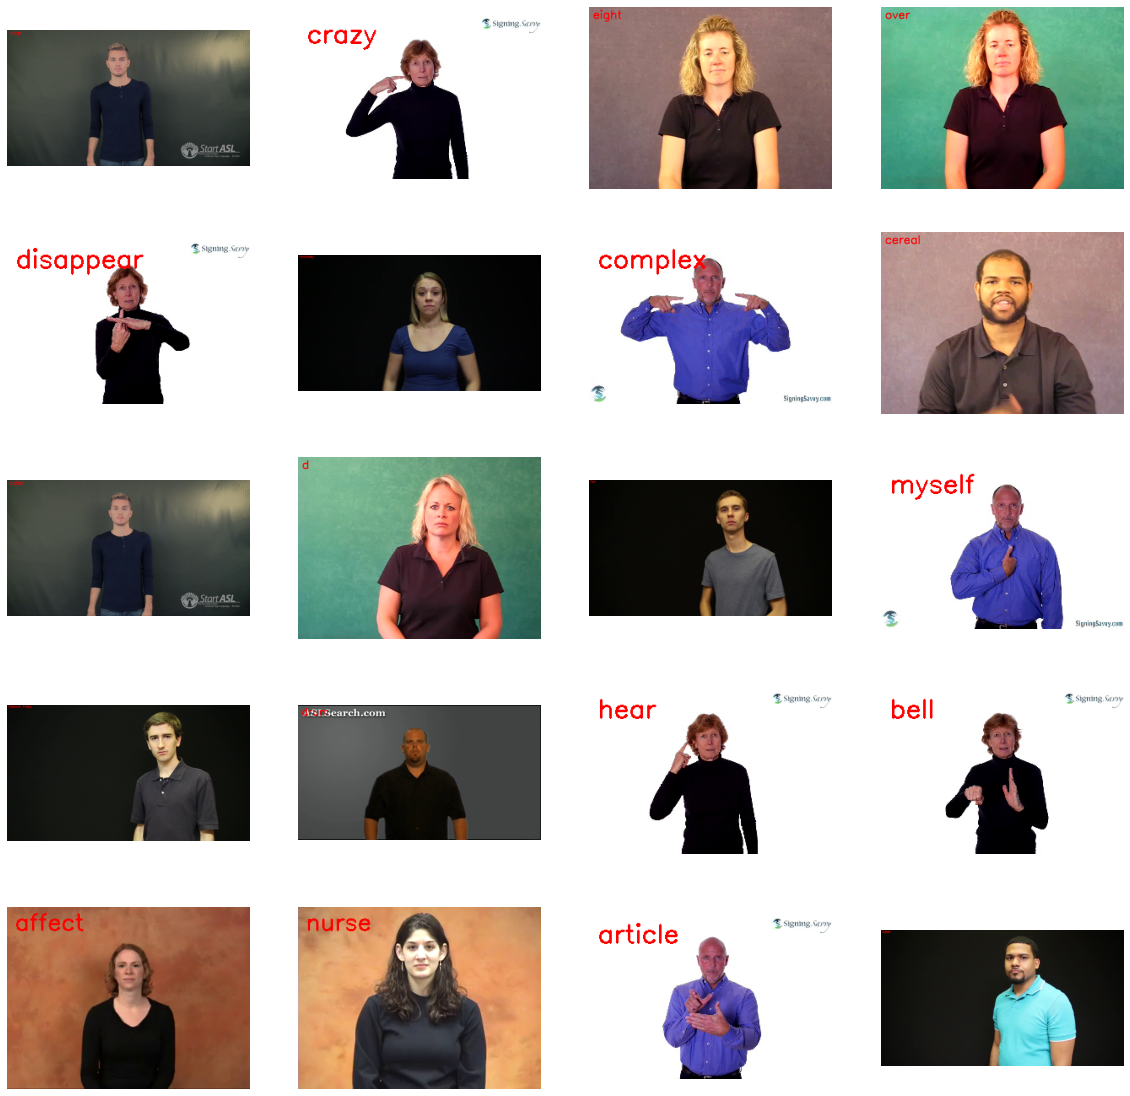

In [ ]:
# Create a Matplotlib figure and specify the size of the figure
plt.figure(figsize=(20, 20))

# Get the names of all classes/categories in UCF50
all_classes_names = os.listdir(DATASET_DIR)

# generate a list of 20 random values. The values will be between 0-50 where 50 is the
# total number of classes in the dataset
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve the list of all the video files present in the randomly selected Class Directory
    video_files_names_list = os.listdir(DATASET_DIR)

    #Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
    
    # Retrieve a Class Name using the Random Index.
    idx = get_index_of_video(selected_video_file_name.split(".")[0])
    selected_class_Name = features_df.iloc[idx].gloss
    # xmin, ymin, xmax, ymax
    bbox = features_df.iloc[idx].bbox

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{DATASET_DIR}{selected_video_file_name}')

    # Read the first frame of the video file
    _, bgr_frame = video_reader.read()

    # release the video object
    video_reader.release()

    #  convert the frame from VGR into RBG format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    #rgb_frame = bounding_box_img(rgb_frame, bbox)
    #cv2.rectangle(rgb_frame,(bbox[0],bbox[1]),(bbox[0]+(bbox[2]-bbox[0]),bbox[1]+(bbox[3]-bbox[1])),(0,255,0),2)
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Display the frame
    plt.subplot(5, 4, counter); plt.imshow(rgb_frame);plt.axis('off')
   


## **<font style="color:#112B3C">Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

### **<font style="color:#205375">Create a Function to Extract, Resize & Normalize Frames</font>**

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames. 

In [ ]:
def bounding_box_img(img,bbox):
  x_min, y_min, x_max, y_max = bbox
  bbox_obj = img[y_min:y_max, x_min:x_max]
  return bbox_obj

In [ ]:
def frames_extraction(video_path, bbox):
    """
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
    video_path: The path of the video in the disk, whose frames are to be extracted.

    Returns:
    frames_list: A list containing the resized and normalized frames of the video.
    """

    # Declare a list to store video frames.
    frames_list = []

    # Read the video File using the videoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    # Iterate through the Video frames:
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # check if the video frame is not successfully read the break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        frame = bounding_box_img(frame, bbox)
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies wetween 0 and 1
        normalized_frame = resized_frame / 255 

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # return the frames list.
    return frames_list


### **<font style="color:#205375">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the video located in the **`DATASET_DIR`** constant and will call the function  **`frame_extraction()`** on every video file and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [ ]:
def bounding_box_img(img,bbox):
  x_min, y_min, x_max, y_max = bbox
  bbox_obj = img[y_min:y_max, x_min:x_max]
  return bbox_obj

In [ ]:
def create_dataset():
    """
    This function will extract the data of the videos and create the required dataset.
    Retuns:
    features: A list containing the extracted frames of the videos.
    labels :  A list containing the indexes of the classes associated with the video
    video_files_paths :  A list containing the paths of the videos in the disk.
    """

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    split = []
       

    # Get the list of video files present in the specific class name directory.
    files_list = os.listdir(DATASET_DIR)
    count = 0
    for file_name in files_list:

        # Display the name of the video whose data is being extracted and its number in iterations
        

        # Get the complete video path.
        video_file_path = os.path.join(DATASET_DIR, file_name)
        idx = get_index_of_video(file_name.split(".")[0])
        selected_class_Name = features_df.iloc[idx].gloss
        bbox = features_df.iloc[idx].bbox
        
        if selected_class_Name in TOP_N_CLASSES:
          print(f"Extracting Data of file: {file_name}, number: {count}")
          
          # Extract the frames of the video file.
          frames = frames_extraction(video_file_path, bbox)
          #frames = load_rgb_frames_from_video(DATASET_DIR, file_name, 1, SEQUENCE_LENGTH)

          # check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
          # So ignore the videos having less than the SEQUENCE_LENGTH.
          if len(frames) == SEQUENCE_LENGTH:

              # get the video's class name
              class_index = features_df.iloc[idx].gloss_indx
              splt = features_df.iloc[idx].split
              # Append the data to their repective list
              features.append(frames)
              labels.append(class_index)
              video_files_paths.append(video_file_path)
              split.append(splt)
              count = count +1
              

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)
    split = np.asarray(split)

    # Return the frames, class_index and video_file_path
    return features, labels, split

Now we will utilize the function **`create_dataset()`** created above to extract the data and create the required dataset.

In [ ]:
# Creat the dataset
features, labels, split = create_dataset()

Extracting Data of file: 24940.mp4, number: 0
Extracting Data of file: 24973.mp4, number: 1
Extracting Data of file: 24956.mp4, number: 2
Extracting Data of file: 24946.mp4, number: 3
Extracting Data of file: 24955.mp4, number: 4
Extracting Data of file: 24952.mp4, number: 5
Extracting Data of file: 24943.mp4, number: 6
Extracting Data of file: 24962.mp4, number: 7
Extracting Data of file: 24947.mp4, number: 8
Extracting Data of file: 24961.mp4, number: 9
Extracting Data of file: 24960.mp4, number: 10
Extracting Data of file: 24941.mp4, number: 11
Extracting Data of file: 24954.mp4, number: 12
Extracting Data of file: 13196.mp4, number: 13
Extracting Data of file: 13203.mp4, number: 14
Extracting Data of file: 13198.mp4, number: 15
Extracting Data of file: 13197.mp4, number: 16
Extracting Data of file: 12317.mp4, number: 17
Extracting Data of file: 12338.mp4, number: 18
Extracting Data of file: 12318.mp4, number: 19
Extracting Data of file: 12328.mp4, number: 20
Extracting Data of file

## **<font style="color:#112B3C">Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [ ]:
train_data = []
train_labels = []
test_data = []
test_labels = []
for i in range(len(split)):
  if split[i]=="train":
    train_data.append(features[i])
    train_labels.append(labels[i])
  else:
    test_data.append(features[i])
    test_labels.append(labels[i])

train_data = np.asarray(train_data)
train_labels = np.array(train_labels)

test_data = np.asarray(test_data)
test_labels = np.array(test_labels)

In [ ]:
NB_CLASSES = len(set(train_labels))
NB_CLASSES

4

In [ ]:
train_data.shape

(40, 20, 64, 64, 3)

## **<font style="color:#112B3C">ConvLSTM Approach</font>**

In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation. 

<center>
<img src="https://drive.google.com/uc?export=view&id=1KHN_JFWJoJi1xQj_bRdxy2QgevGOH1qP" width= 500px>
</center>


For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input `(width, height, num_of_channels)` whereas a simple LSTM only takes in 1-dimensional input hence an LSTM is incompatible for modeling Spatio-temporal data on its own.

You can read the paper [**Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting**](https://arxiv.org/abs/1506.04214v1) by **Xingjian Shi** (NIPS 2015), to learn more about this architecture.


### **<font style="color:#205375">Construct the Model</font>**


To construct the model, we will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the **`Dense`** layer with softmax activation which outputs the probability of each action category. 

We will also use **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(NB_CLASSES, activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Now we will utilize the function **`create_convlstm_model()`** created above, to construct the required `convlstm` model.

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

In [ ]:
train_labels

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = train_data, y = tf.one_hot(train_labels, NB_CLASSES), epochs = 50, batch_size = 4,
                                                     validation_data=(test_data, tf.one_hot(test_labels, NB_CLASSES)))

Epoch 1/50
10/10 [==============================] - 21s 370ms/step - loss: 1.3753 - accuracy: 0.2750 - val_loss: 1.3943 - val_accuracy: 0.3333
Epoch 2/50
10/10 [==============================] - 2s 249ms/step - loss: 1.3409 - accuracy: 0.3500 - val_loss: 1.3386 - val_accuracy: 0.3333
Epoch 3/50
10/10 [==============================] - 2s 249ms/step - loss: 1.2960 - accuracy: 0.4000 - val_loss: 1.5442 - val_accuracy: 0.3333
Epoch 4/50
10/10 [==============================] - 2s 247ms/step - loss: 1.1608 - accuracy: 0.4000 - val_loss: 1.3809 - val_accuracy: 0.2667
Epoch 5/50
10/10 [==============================] - 3s 254ms/step - loss: 1.1220 - accuracy: 0.5250 - val_loss: 1.5387 - val_accuracy: 0.2667
Epoch 6/50
10/10 [==============================] - 2s 251ms/step - loss: 1.1172 - accuracy: 0.3750 - val_loss: 1.6554 - val_accuracy: 0.3333
Epoch 7/50
10/10 [==============================] - 2s 246ms/step - loss: 0.9986 - accuracy: 0.6250 - val_loss: 1.6126 - val_accuracy: 0.1333
Epoch

In [ ]:
convlstm_model.evaluate(test_data, to_categorical(test_labels))

1/1 [==============================] - 0s 147ms/step - loss: 3.5676 - accuracy: 0.5333


[3.5676395893096924, 0.5333333611488342]

In [ ]:
activation='relu'

In [ ]:
model_2 = Sequential()

# Define the Model Architecture.
########################################################################################################################

model_2.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = activation,data_format = "channels_last",
                    recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model_2.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model_2.add(TimeDistributed(Dropout(0.2)))

model_2.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = activation, data_format = "channels_last",
                    recurrent_dropout=0.2, return_sequences=True))

model_2.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model_2.add(TimeDistributed(Dropout(0.2)))

model_2.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = activation, data_format = "channels_last",
                    recurrent_dropout=0.2, return_sequences=True))

model_2.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model_2.add(TimeDistributed(Dropout(0.2)))

model_2.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = activation, data_format = "channels_last",
                    recurrent_dropout=0.2, return_sequences=True))

model_2.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#model.add(TimeDistributed(Dropout(0.2)))

model_2.add(Flatten()) 

model_2.add(Dense(NB_CLASSES, activation = "softmax"))

########################################################################################################################

# Display the models summary.
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 20, 31, 31, 4)    0         
 3D)                                                             
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 31, 31, 4)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                      

In [ ]:
# Compile the model and specify loss function, optimizer and metrics values to the model
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
model_2_history = model_2.fit(x = train_data, y = tf.one_hot(train_labels, NB_CLASSES), epochs = 50, batch_size = 4,
                                                     validation_data=(test_data, tf.one_hot(test_labels, NB_CLASSES)))

Epoch 1/50
10/10 [==============================] - 9s 342ms/step - loss: 1.3872 - accuracy: 0.1750 - val_loss: 1.3861 - val_accuracy: 0.3333
Epoch 2/50
10/10 [==============================] - 3s 254ms/step - loss: 1.3808 - accuracy: 0.2750 - val_loss: 1.3837 - val_accuracy: 0.3333
Epoch 3/50
10/10 [==============================] - 2s 251ms/step - loss: 1.4794 - accuracy: 0.3750 - val_loss: 1.3980 - val_accuracy: 0.3333
Epoch 4/50
10/10 [==============================] - 2s 251ms/step - loss: 1.3241 - accuracy: 0.4750 - val_loss: 1.3881 - val_accuracy: 0.2000
Epoch 5/50
10/10 [==============================] - 3s 254ms/step - loss: 1.3655 - accuracy: 0.3250 - val_loss: 1.3938 - val_accuracy: 0.2667
Epoch 6/50
10/10 [==============================] - 2s 250ms/step - loss: 1.3430 - accuracy: 0.4000 - val_loss: 1.3819 - val_accuracy: 0.2000
Epoch 7/50
10/10 [==============================] - 2s 250ms/step - loss: 1.3368 - accuracy: 0.4000 - val_loss: 1.3794 - val_accuracy: 0.2000
Epoch 

In [ ]:
model_2.evaluate(test_data, to_categorical(test_labels))

1/1 [==============================] - 0s 243ms/step - loss: 3.5384 - accuracy: 0.3333


[3.5383825302124023, 0.3333333432674408]

In [9]:
# Specify the hight and width each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
NB_CLASSES = 4
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

In [10]:
model_3 = Sequential()

# Define the Model Architecture.
########################################################################################################################

model_3.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = "tanh", use_bias=True,
                    recurrent_dropout=0.4, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model_3.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_first'))
model_3.add(TimeDistributed(Dropout(0.2)))

#model.add(TimeDistributed(Dropout(0.2)))

model_3.add(Flatten()) 

model_3.add(Dense(NB_CLASSES, activation = "softmax"))

########################################################################################################################

# Display the models summary.
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 62, 31, 2)    0         
 3D)                                                             
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 62, 31, 2)    0         
 tributed)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 76880)             0         
                                                                 
 dense (Dense)               (None, 4)                 307524    
                                                                 
Total params: 308,548
Trainable params: 308,548
Non-tr

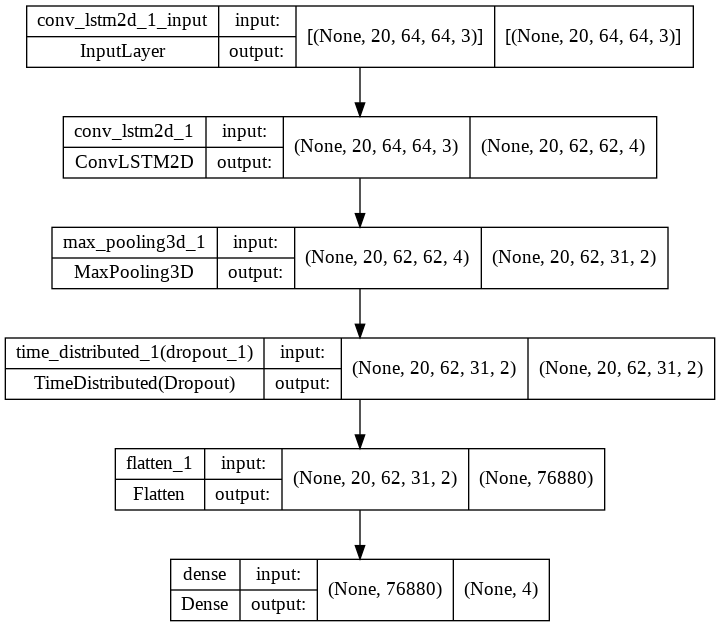

In [11]:
# Plot the structure of the contructed LRCN model.
plot_model(model_3, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'auto', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
model_3.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
model_3_history = model_3.fit(x = train_data, y = tf.one_hot(train_labels, NB_CLASSES), epochs = 50, batch_size = 20,
                                                     validation_data=(test_data, tf.one_hot(test_labels, NB_CLASSES)))

Epoch 1/50
2/2 [==============================] - 3s 445ms/step - loss: 5.1313 - accuracy: 0.3750 - val_loss: 7.0808 - val_accuracy: 0.2667
Epoch 2/50
2/2 [==============================] - 0s 131ms/step - loss: 4.7195 - accuracy: 0.2000 - val_loss: 6.4102 - val_accuracy: 0.3333
Epoch 3/50
2/2 [==============================] - 0s 137ms/step - loss: 3.4600 - accuracy: 0.4250 - val_loss: 3.3042 - val_accuracy: 0.2000
Epoch 4/50
2/2 [==============================] - 0s 128ms/step - loss: 1.7436 - accuracy: 0.5000 - val_loss: 2.5591 - val_accuracy: 0.2667
Epoch 5/50
2/2 [==============================] - 0s 168ms/step - loss: 1.5606 - accuracy: 0.4750 - val_loss: 1.8230 - val_accuracy: 0.5333
Epoch 6/50
2/2 [==============================] - 0s 130ms/step - loss: 1.4554 - accuracy: 0.5250 - val_loss: 1.8438 - val_accuracy: 0.3333
Epoch 7/50
2/2 [==============================] - 0s 131ms/step - loss: 1.2315 - accuracy: 0.5000 - val_loss: 1.5841 - val_accuracy: 0.4000
Epoch 8/50
2/2 [====

In [ ]:
model_3.evaluate(test_data, to_categorical(test_labels))

1/1 [==============================] - 0s 50ms/step - loss: 1.4006 - accuracy: 0.5333


[1.400573492050171, 0.5333333611488342]

In [ ]:
model_4 = Sequential()

# Define the Model Architecture.
########################################################################################################################

model_4.add(ConvLSTM2D(filters = 3, kernel_size = (3, 3), activation = "tanh", use_bias=True,
                    recurrent_dropout=0.4, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model_4.add(MaxPooling3D(pool_size=(1, 3, 3), padding='same', data_format='channels_last'))
model_4.add(TimeDistributed(Dropout(0.4)))

#model.add(TimeDistributed(Dropout(0.2)))

model_4.add(Flatten()) 

model_4.add(Dense(NB_CLASSES, activation = "softmax"))

########################################################################################################################

# Display the models summary.
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_11 (ConvLSTM2D)  (None, 20, 62, 62, 3)    660       
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 20, 21, 21, 3)    0         
 3D)                                                             
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 21, 21, 3)    0         
 tributed)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 26460)             0         
                                                                 
 dense_3 (Dense)             (None, 4)                 105844    
                                                                 
Total params: 106,504
Trainable params: 106,504
Non-tr

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'auto', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
model_4.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
model_4_history = model_4.fit(x = train_data, y = tf.one_hot(train_labels, NB_CLASSES), epochs = 50, batch_size = 20,
                                                     validation_data=(test_data, tf.one_hot(test_labels, NB_CLASSES)))

Epoch 1/50
2/2 [==============================] - 2s 457ms/step - loss: 1.4429 - accuracy: 0.3000 - val_loss: 1.5347 - val_accuracy: 0.3333
Epoch 2/50
2/2 [==============================] - 0s 114ms/step - loss: 1.2780 - accuracy: 0.3750 - val_loss: 1.5686 - val_accuracy: 0.3333
Epoch 3/50
2/2 [==============================] - 0s 112ms/step - loss: 1.0990 - accuracy: 0.5500 - val_loss: 1.5921 - val_accuracy: 0.2667
Epoch 4/50
2/2 [==============================] - 0s 117ms/step - loss: 0.9391 - accuracy: 0.6250 - val_loss: 1.4768 - val_accuracy: 0.3333
Epoch 5/50
2/2 [==============================] - 0s 112ms/step - loss: 0.8115 - accuracy: 0.6750 - val_loss: 1.4109 - val_accuracy: 0.4667
Epoch 6/50
2/2 [==============================] - 0s 116ms/step - loss: 0.7824 - accuracy: 0.6750 - val_loss: 1.3511 - val_accuracy: 0.4667
Epoch 7/50
2/2 [==============================] - 0s 114ms/step - loss: 0.6868 - accuracy: 0.8000 - val_loss: 1.3600 - val_accuracy: 0.4667
Epoch 8/50
2/2 [====

In [ ]:
model_4.evaluate(test_data, to_categorical(test_labels))

1/1 [==============================] - 0s 49ms/step - loss: 3.6004 - accuracy: 0.4667


[3.600369691848755, 0.46666666865348816]

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
#model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
#model_file_name = f'models/convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
model_file_name = f'models/convlstm_model3.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### **<font style="color:#205375">Plot Model’s Loss & Accuracy Curves</font>**


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

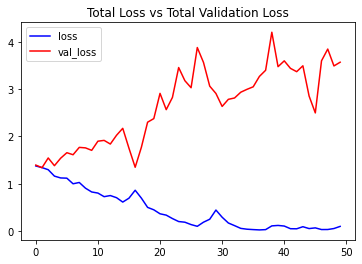

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

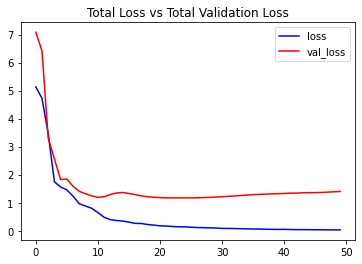

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(model_3_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

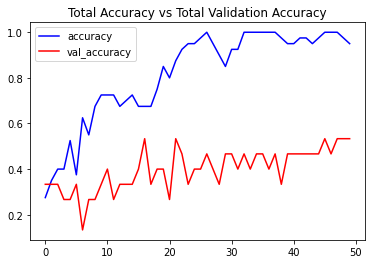

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

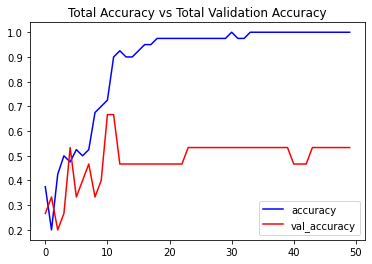

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_3_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

### **<font style="color:#205375">Create a Function to Download YouTube Videos:</font>**

We will create a function **`download_youtube_videos()`** to download the YouTube videos first using **`pafy`** library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

### **<font style="color:#205375">Download a Test Video:</font>**

Now we will utilize the function **`download_youtube_videos()`** created above to download a youtube video on which the `LRCN` model will be tested.

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

In [ ]:
ls

features_df.csv  nslt_1000.json  nslt_300.json  tmp/
missing.txt      nslt_100.json   sample.mp4     videos/
models/          nslt_2000.json  test_videos/   WLASL_v0.3.json


In [ ]:
features_df[features_df['gloss'] == "computer"]

,gloss,video_id,url,gloss_indx
index,,,,
17,computer,12328,https://www.signingsavvy.com/signs/mp4/6/6326.mp4,1
18,computer,12312,https://s3-us-west-1.amazonaws.com/files.start...,1
19,computer,12311,https://media.spreadthesign.com/video/mp4/13/5...,1
20,computer,12338,http://www.aslsearch.com/signs/videos/computer...,1
21,computer,12313,https://s3-us-west-1.amazonaws.com/files.start...,1
22,computer,12314,https://signstock.blob.core.windows.net/signsc...,1
23,computer,12315,https://signstock.blob.core.windows.net/signsc...,1
24,computer,12316,https://signstock.blob.core.windows.net/signsc...,1
25,computer,12317,https://signstock.blob.core.windows.net/signsc...,1


In [ ]:
TOP_N_CLASSES

['before', 'computer', 'cool', 'go']

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform ASL on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the ASL is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = model_3.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
input_video_file_path = "videos/12328.mp4"
video_title = "computer_test"

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

In [ ]:
pip install setuptools 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from moviepy.editor import VideoFileClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4128768/45929032 bytes (9.0%)8175616/45929032 bytes (17.8%)12263424/45929032 bytes (26.7%)16138240/45929032 bytes (35.1%)20258816/45929032 bytes (44.1%)24461312/45929032 bytes (53.3%)28565504/45929032 bytes (62.2%)32686080/45929032 bytes (71.2%)36577280/45929032 bytes (79.6%)40697856/45929032 bytes (88.6%)44802048/45929032 bytes (97.5%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 89/89 [00:00<00:00, 370.51it/s]


In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=ILJfwyR8PP4', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

In [ ]:
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 79/79 [00:00<00:00, 420.82it/s]


In [ ]:
# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=bqKb9hkQfQ4', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'


# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
#predict_on_video(f'{DATASET_DIR}/69241.mp4', output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 89/89 [00:00<00:00, 233.87it/s]


In [ ]:
features_df[features_df['gloss'] == "before"]

,gloss,video_id,url,split,bbox,gloss_indx
index,,,,,,
31,before,05728,https://signstock.blob.core.windows.net/signsc...,train,"[624, 70, 1587, 1070]",0
32,before,05749,http://www.aslsearch.com/signs/videos/before3.mp4,train,"[167, 52, 512, 400]",0
33,before,05750,http://www.aslsearch.com/signs/videos/before.mp4,val,"[171, 52, 513, 400]",0
34,before,05729,https://signstock.blob.core.windows.net/signsc...,train,"[300, 12, 1202, 1080]",0
35,before,05730,https://signstock.blob.core.windows.net/signsc...,train,"[712, 64, 1652, 1080]",0
36,before,05731,https://signstock.blob.core.windows.net/signsc...,train,"[570, 98, 1535, 1080]",0
37,before,05732,https://media.asldeafined.com/vocabulary/14666...,train,"[103, 25, 528, 480]",0
38,before,05733,https://media.asldeafined.com/vocabulary/14666...,train,"[95, 23, 533, 480]",0
39,before,05734,https://media.asldeafined.com/vocabulary/14687...,train,"[129, 0, 555, 480]",0


In [ ]:
input_video_file_path = "videos/05728.mp4"
video_title = "before_test"
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 27/27 [00:00<00:00, 112.86it/s]


In [ ]:
input_video_file_path = "videos/05743.mp4"
video_title = "before_test"
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 48/48 [00:00<00:00, 348.85it/s]


In [ ]:
input_video_file_path = "videos/05732.mp4"
video_title = "before_test"
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 87/87 [00:00<00:00, 335.64it/s]


## General Test

In [ ]:


# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=UQtL53JgftI', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'


# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
#predict_on_video(f'{DATASET_DIR}/69241.mp4', output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()